## Topic Modeling: Latent Dirichlet Allocation with gensim

### Imports

In [1]:
% matplotlib inline
import warnings
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for topic models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim import prepare

In [2]:
plt.style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

## Load Yelp Reviews

In [4]:
yelp_path = Path('data', 'yelp')

In [6]:
reviews = pd.read_parquet(yelp_path / 'combined_tb.parquet', engine='fastparquet')
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Data columns (total 26 columns):
cool                  5996995 non-null int64
funny                 5996995 non-null int64
stars                 5996995 non-null int64
text                  5996995 non-null object
useful                5996995 non-null int64
year                  5996995 non-null int64
month                 5996995 non-null int64
average_stars         5996995 non-null float64
compliment_cool       5996995 non-null int64
compliment_cute       5996995 non-null int64
compliment_funny      5996995 non-null int64
compliment_hot        5996995 non-null int64
compliment_list       5996995 non-null int64
compliment_more       5996995 non-null int64
compliment_note       5996995 non-null int64
compliment_photos     5996995 non-null int64
compliment_plain      5996995 non-null int64
compliment_profile    5996995 non-null int64
compliment_writer     5996995 non-null int64
cool_user             5996995

### Tokens per review

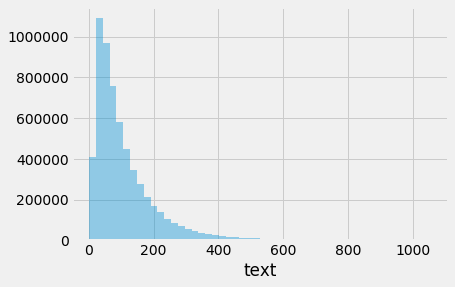

In [7]:
sns.distplot(reviews.text.str.split().str.len(), kde=False);

In [10]:
token_count = Counter()
for i, doc in enumerate(reviews.text.tolist(), 1):
    if i % 100000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 3500000 3600000 3700000 3800000 3900000 4000000 4100000 4200000 4300000 4400000 4500000 4600000 4700000 4800000 4900000 5000000 5100000 5200000 5300000 5400000 5500000 5600000 5700000 5800000 5900000 

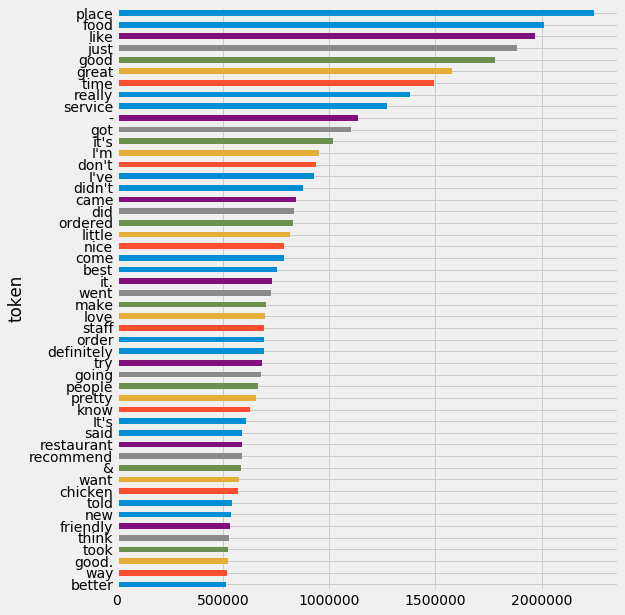

In [11]:
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:50]
 .sort_values()
 .plot
 .barh(figsize=(8, 10)));

### Preprocessing

In [12]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [23]:
nlp = spacy.load('en')
nlp.max_length = 6000000
nlp.disable_pipes('ner')

[('ner', <spacy.pipeline.EntityRecognizer at 0x7f5b8955fe08>)]

In [24]:
nlp.pipe_names

['tagger', 'parser']

In [ ]:
iter_reviews = (review for review in reviews.text)
clean_reviews = []
for i, doc in enumerate(nlp.pipe(iter_reviews, batch_size=100, n_threads=8)):
    if i % 10000 == 0: 
        print(f'{i/len(reviews):.2%}', end=' ', flush=True)
    clean_reviews.append(clean_doc(doc))

In [ ]:
clean_reviews = [clean_doc(doc) for doc in parsed_reviews]

In [ ]:
Path('data', 'yelp', 'clean_reviews.txt').write_text('\n'.join(clean_reviews))

### Vectorize data

In [32]:
clean_reviews = (Path('data', 'yelp', 'clean_reviews.txt')
                 .read_text()
                 .split('\n'))
len(clean_reviews)

170000

In [319]:
doc_vect = CountVectorizer(stop_words=stops,
                           min_df=100,
                           max_df=.2,
                           ngram_range=(1,2),
                           binary=False)
doc_dtm = doc_vect.fit_transform(clean_docs)
doc_tokens = doc_vect.get_feature_names()

In [320]:
doc_dtm.shape

(19134, 1228)

In [321]:
doc_corpus = Sparse2Corpus(doc_dtm, documents_columns=False)
doc_id2word = pd.Series(doc_tokens).to_dict()
doc_dictionary = Dictionary.from_corpus(doc_corpus, doc_id2word)

In [322]:
num_topics=25
chunksize=2000
passes=10
update_every=None
alpha='auto'
eta='auto'
decay=0.5
offset=1.0
eval_every=None
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

In [323]:
%%time
doc_model = LdaModel(corpus=doc_corpus,
                     id2word=doc_id2word,
                     num_topics=num_topics,
                     chunksize=chunksize,
                     update_every=update_every,
                     alpha=alpha,
                     eta=eta,
                     decay=decay,
                     offset=offset,
                     eval_every=eval_every,
                     passes=passes,
                     iterations=iterations,
                     gamma_threshold=gamma_threshold,
                     minimum_probability=minimum_probability,
                     minimum_phi_value=minimum_phi_value,
                     random_state=42)

CPU times: user 55.3 s, sys: 8.76 s, total: 1min 4s
Wall time: 51.7 s


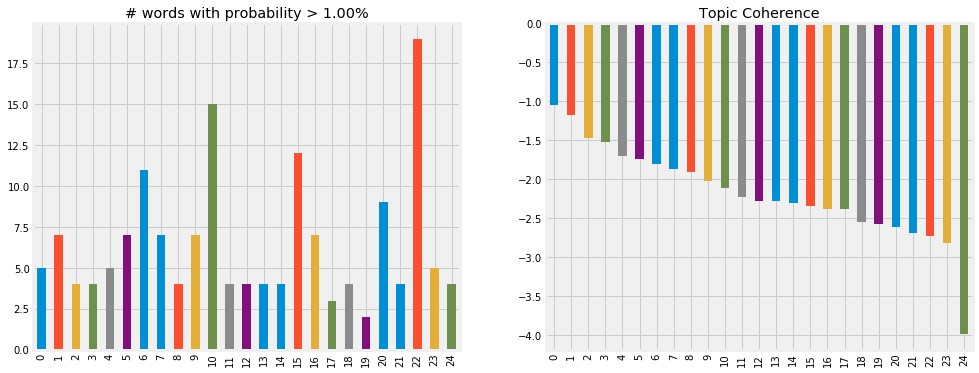

In [324]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

cutoff = 0.01
word_list = pd.DataFrame(doc_model.get_topics().T)
(word_list>cutoff).sum().plot.bar(title=f'# words with probability > {cutoff:.2%}', ax=axes[0]);

umass = doc_model.top_topics(corpus=doc_corpus, coherence='u_mass', topn=20)
pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[1]);

In [325]:
vis = prepare(doc_model, doc_corpus, doc_dictionary, mds='tsne')
pyLDAvis.display(vis)

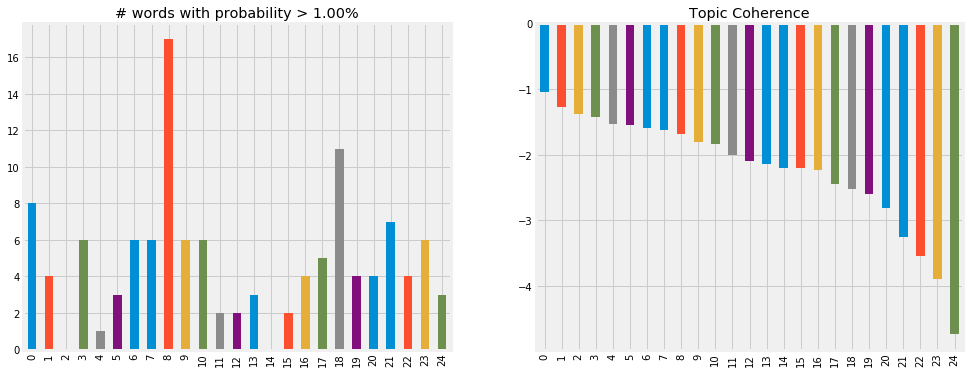

In [292]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

cutoff = 0.01
word_list = pd.DataFrame(doc_model.get_topics().T)
(word_list>cutoff).sum().plot.bar(title=f'# words with probability > {cutoff:.2%}', ax=axes[0]);

umass = doc_model.top_topics(corpus=doc_corpus, coherence='u_mass', topn=20)
pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[1]);

In [294]:
vis = prepare(doc_model, doc_corpus, doc_dictionary, mds='tsne')
pyLDAvis.display(vis)

### Train Model & Review Results

In [81]:
model_path = Path('results', 'models')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

In [91]:
lda = {}
coherence = pd.DataFrame()

for n_topics in [2, 3, 4, 5, 7, 10, 15, 20, 25]:
    print(n_topics, end=' ', flush=True)
    lda = LdaModel(corpus=corpus,
                             num_topics=n_topics,
                             id2word=id2word,
                             passes=1)
    lda.save(str((model_path / f'{n_topics}')))
    with pd.HDFStore(model_path / 'topics.h5') as store:
        store.put(f'topic_words/{n_topics}', pd.DataFrame(lda.get_topics(), columns=tokens).T)
    umass = lda.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    coherence = pd.concat([coherence, pd.Series([c[1] for c in umass]).to_frame(n_topics)], axis=1)
    break
print(coherence)

2       2
0 -1.21
1 -1.41


In [ ]:
LdaModel(corpus=None, 
         num_topics=100, 
         id2word=None, 
         distributed=False, 
         chunksize=2000,                   # Number of documents to be used in each training chunk.
         passes=1,                         # Number of passes through the corpus during training
         update_every=1,                   # Number of docs to be iterated through for each update
         alpha='symmetric', 
         eta=None,                         # a-priori belief on word probability
         decay=0.5,                        # percentage of previous lambda forgotten when new document is examined
         offset=1.0,                       # controls slow down of the first steps the first few iterations.
         eval_every=10,                    # estimate log perplexity
         iterations=50,                    # Maximum number of iterations through the corpus
         gamma_threshold=0.001,            # Minimum change in the value of the gamma parameters to continue iterating
         minimum_probability=0.01,         # Topics with a probability lower than this threshold will be filtered out
         random_state=None, 
         ns_conf=None, 
         minimum_phi_value=0.01,           # if `per_word_topics` is True, represents lower bound on term probabilities
         per_word_topics=False,            #  If True, compute a list of most likely topics for each word with phi values multiplied by word count
         callbacks=None, 
         dtype=<class 'numpy.float32'>)

In [90]:
n_topics=10
lda = LdaModel.load(str((model_path / f'{n_topics}')))
dictionary = Dictionary.from_corpus(corpus, id2word)
vis = prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

## Experiments

In [93]:
nlp = spacy.load('en')

# Combine spacy and linguistic utils stopwords
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                         header=None,
                         squeeze=True)

for stop_word in stop_words:
    STOP_WORDS.add(stop_word)

In [ ]:
documents = []
for transcript in earnings_path.iterdir():
    content = pd.read_csv(transcript / 'content.csv')
    documents.extend(content.loc[(content.speaker!='Operator') & (content.content.str.len() > 5), 'content'].tolist())

In [102]:
clean_sentences = []
for i, document in enumerate(documents, 1):
    if i % 1000 == 0: 
        print(f'{i/len(documents):.2%}', end=' ', flush=True)
    doc = nlp(document)
    for sent in doc.sents:
        clean_sentences.append(clean_doc(sent))

5.23% 10.45% 15.68% 20.91% 26.13% 31.36% 36.58% 41.81% 47.04% 52.26% 57.49% 62.72% 67.94% 73.17% 78.39% 83.62% 88.85% 94.07% 99.30% 

In [104]:
Path('data', 'clean_sentences.txt').write_text('\n'.join(clean_sentences))

8982391

In [149]:
word_count = Counter([len(s) for s in clean_sentences])

In [151]:
pd.Series(dict(word_count.most_common())).describe()

count     410.00
mean      349.90
std       526.05
min         1.00
25%         3.00
50%        43.50
75%       552.00
max     3,534.00
dtype: float64

In [231]:
token_count = Counter()
for i, doc in enumerate(clean_sentences, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 

In [243]:
top_tokens = pd.Series(dict(token_count.most_common(100))).sort_values(ascending=False)
top_tokens.head(10)

year        21195
quarter     17651
and         14367
million     13942
so          12577
think       10347
business     8917
thank        7604
growth       7575
look         7220
dtype: int64

In [244]:
len(stop_words.ENGLISH_STOP_WORDS)

318

In [245]:
stops = stop_words.ENGLISH_STOP_WORDS | set(top_tokens.index)

In [254]:
short_sentences = [s for s in clean_sentences if len(s) > 10]

In [255]:
binary_vectorizer = CountVectorizer(max_df=1.0,
                             min_df=1,
                             stop_words=stops,
                             max_features=None,
                             binary=True)

binary_dtm = binary_vectorizer.fit_transform(short_sentences)

n_docs, n_tokens = binary_dtm.shape
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(binary_dtm.shape[0])
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [256]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
#     axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

In [263]:
vectorizer = CountVectorizer(stop_words=stops, min_df=25, max_df=.1, binary=False)
dtm = vectorizer.fit_transform(short_sentences)
words = vectorizer.get_feature_names()
dtm

<128037x3405 sparse matrix of type '<class 'numpy.int64'>'
	with 656580 stored elements in Compressed Sparse Row format>

In [264]:
tokens = vectorizer.get_feature_names()
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

In [265]:
num_topics=15
chunksize=2000
passes=1
update_every=None
alpha='auto'
eta='auto'
decay=0.5
offset=1.0
eval_every=None
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

In [266]:
%%time
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 num_topics=num_topics,
                 chunksize=chunksize,
                 update_every=update_every,
                 alpha=alpha,
                 eta=eta,
                 decay=decay,
                 offset=offset,
                 eval_every=eval_every,
                 passes=passes,
                 iterations=iterations,
                 gamma_threshold=gamma_threshold,
                 minimum_probability=minimum_probability,
                 minimum_phi_value=minimum_phi_value,
                 random_state=42)

CPU times: user 21 s, sys: 8.94 ms, total: 21 s
Wall time: 21 s


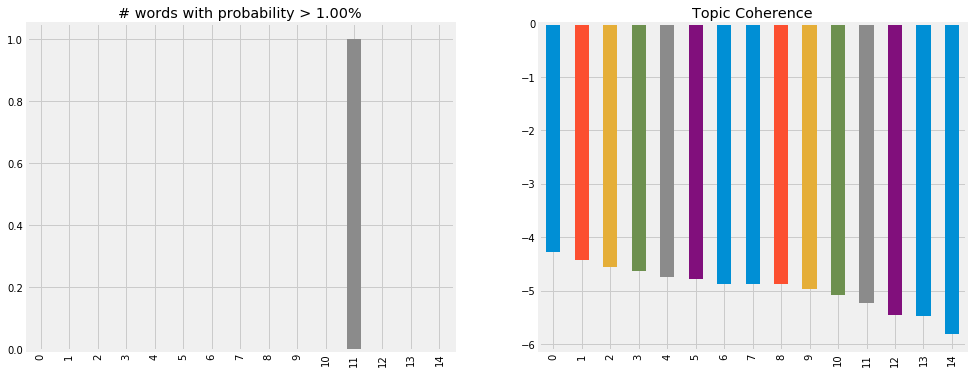

In [267]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))

cutoff = 0.01
word_list = pd.DataFrame(model.get_topics().T)
(word_list>cutoff).sum().plot.bar(title=f'# words with probability > {cutoff:.2%}', ax=axes[0]);

umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[1]);

In [268]:
vis = prepare(model, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)